**installing and importing Pyspark and initializing session**

In [ ]:
!pip install pyspark
import pyspark
from pyspark.sql import SparkSession
spark = pyspark.sql.SparkSession.builder.appName("My PySpark App").getOrCreate()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285398 sha256=452477f9eb1072bed6e4ddd5b57bcdd3fbf4af879336e0484bce51ab62d9baae
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


**Loading the datasets of Ghor al Safi and Irbid**


In [ ]:
df_ghor_al_safi_weather_data = spark.read.csv("/content/drive/MyDrive/Big Data/ghor_al_safi_weather_data.csv", header=True)

df_irbid_weather_data = spark.read.csv("/content/drive/MyDrive/Big Data/irbid_weather_data.csv", header=True)

df_ghor_al_safi_crop_production = spark.read.csv("/content/drive/MyDrive/Big Data/ghor_al_safi_crop_production_data.csv", header=True)

df_irbid_crop_production = spark.read.csv("/content/drive/MyDrive/Big Data/irbid_crop_production.csv", header=True)

In [ ]:
df_ghor_al_safi_weather_data.printSchema()
df_irbid_weather_data.printSchema()

root
 |-- Station: string (nullable = true)
 |-- Date/Time: string (nullable = true)
 |-- Air Dew Point: string (nullable = true)
 |-- Air Temperature (OC): string (nullable = true)
 |-- Humidity %: string (nullable = true)
 |-- Manual Present Weather …: string (nullable = true)
 |-- Cloud Type: string (nullable = true)
 |-- Clouds Cover (Okta): string (nullable = true)
 |-- Cloud Cover %: string (nullable = true)
 |-- Wind Direction (Degrees): string (nullable = true)
 |-- Wind Speed (MPS): string (nullable = true)
 |-- Wind Type: string (nullable = true)

root
 |-- Station: string (nullable = true)
 |-- Date/Time(year): string (nullable = true)
 |-- Air Dew Point: string (nullable = true)
 |-- Air Temperature (OC): string (nullable = true)
 |-- Humidity %: string (nullable = true)
 |-- Manual Present Weather: string (nullable = true)
 |-- Cloud Type: string (nullable = true)
 |-- Clouds Cover (Okta): string (nullable = true)
 |-- Cloud Cover %: string (nullable = true)
 |-- Wind Dire

**Preprocessing**

In [ ]:
df_ghor_cleaned = df_ghor_al_safi_weather_data.drop("Air Dew Point", "Manual Present Weather …", "cloud type", "Clouds Cover (Okta)", "Wind Type").na.drop(how="any")

df_irbid_cleaned = df_irbid_weather_data.drop("Air Dew Point", "Manual Present Weather", "cloud type", "Clouds Cover (Okta)", "Wind Type").na.drop(how="any")

In [ ]:
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType

# Convert string columns to DoubleType
df_irbid_cleaned = df_irbid_cleaned.withColumn("Air Temperature (OC)", col("Air Temperature (OC)").cast(DoubleType()))
df_irbid_cleaned = df_irbid_cleaned.withColumn("Humidity %", col("Humidity %").cast(DoubleType()))
df_irbid_cleaned = df_irbid_cleaned.withColumn("Cloud Cover %", col("Cloud Cover %").cast(DoubleType()))
df_irbid_cleaned = df_irbid_cleaned.withColumn("Wind Direction (Degrees)", col("Wind Direction (Degrees)").cast(DoubleType()))
df_irbid_cleaned = df_irbid_cleaned.withColumn("Wind Speed (MPS)", col("Wind Speed (MPS)").cast(DoubleType()))

# Convert string columns to DoubleType
df_ghor_cleaned = df_ghor_cleaned.withColumn("Air Temperature (OC)", col("Air Temperature (OC)").cast(DoubleType()))
df_ghor_cleaned = df_ghor_cleaned.withColumn("Humidity %", col("Humidity %").cast(DoubleType()))
df_ghor_cleaned = df_ghor_cleaned.withColumn("Cloud Cover %", col("Cloud Cover %").cast(DoubleType()))
df_ghor_cleaned = df_ghor_cleaned.withColumn("Wind Direction (Degrees)", col("Wind Direction (Degrees)").cast(DoubleType()))
df_ghor_cleaned = df_ghor_cleaned.withColumn("Wind Speed (MPS)", col("Wind Speed (MPS)").cast(DoubleType()))

In [ ]:
df_ghor_cleaned.show()
df_irbid_cleaned.show()

+------------+-------------------+--------------------+----------+-------------+------------------------+----------------+
|     Station|          Date/Time|Air Temperature (OC)|Humidity %|Cloud Cover %|Wind Direction (Degrees)|Wind Speed (MPS)|
+------------+-------------------+--------------------+----------+-------------+------------------------+----------------+
|Ghor El Safi|2017-01-08T12:00:00|                21.0|      37.0|         38.0|                   190.0|             3.0|
|Ghor El Safi|2017-01-09T12:00:00|                20.0|      29.0|         38.0|                   260.0|             2.0|
|Ghor El Safi|2017-01-10T12:00:00|                20.0|      47.0|         38.0|                   350.0|             2.0|
|Ghor El Safi|2017-01-14T12:00:00|                22.0|      47.0|         13.0|                    20.0|             2.0|
|Ghor El Safi|2017-01-16T12:00:00|                21.0|      49.0|         38.0|                   340.0|             2.0|
|Ghor El Safi|20

In [ ]:
from pyspark.sql.functions import mean

In [ ]:
# Calculate the mean values for each column
mean_values = df_ghor_cleaned.select([mean(col(column)).alias(column) for column in df_ghor_cleaned.columns]).collect()[0].asDict()

# Replace null values in the mean values dictionary
mean_values = {column: value if value is not None else 0 for column, value in mean_values.items()}

# Impute missing values with mean values
df_ghor_cleaned = df_ghor_cleaned.fillna(mean_values)

# Display the imputed DataFrame
df_ghor_cleaned.show()

+------------+-------------------+--------------------+----------+-------------+------------------------+----------------+
|     Station|          Date/Time|Air Temperature (OC)|Humidity %|Cloud Cover %|Wind Direction (Degrees)|Wind Speed (MPS)|
+------------+-------------------+--------------------+----------+-------------+------------------------+----------------+
|Ghor El Safi|2017-01-08T12:00:00|                21.0|      37.0|         38.0|                   190.0|             3.0|
|Ghor El Safi|2017-01-09T12:00:00|                20.0|      29.0|         38.0|                   260.0|             2.0|
|Ghor El Safi|2017-01-10T12:00:00|                20.0|      47.0|         38.0|                   350.0|             2.0|
|Ghor El Safi|2017-01-14T12:00:00|                22.0|      47.0|         13.0|                    20.0|             2.0|
|Ghor El Safi|2017-01-16T12:00:00|                21.0|      49.0|         38.0|                   340.0|             2.0|
|Ghor El Safi|20

In [ ]:
from pyspark.sql.functions import mean, col

# Calculate the mean values for each column
mean_values = df_irbid_cleaned.select([mean(col(column)).alias(column) for column in df_irbid_cleaned.columns]).collect()[0].asDict()

# Replace null values in the mean values dictionary
mean_values = {column: value if value is not None else 0 for column, value in mean_values.items()}

# Impute missing values with mean values
df_irbid_cleaned = df_irbid_cleaned.fillna(mean_values)

# Display the imputed DataFrame
df_irbid_cleaned.show()


+-------+-------------------+--------------------+----------+-------------+------------------------+----------------+
|Station|    Date/Time(year)|Air Temperature (OC)|Humidity %|Cloud Cover %|Wind Direction (Degrees)|Wind Speed (MPS)|
+-------+-------------------+--------------------+----------+-------------+------------------------+----------------+
|  Irbid|2017-01-01T09:00:00|                 8.0|      91.0|         25.0|                   300.0|             3.0|
|  Irbid|2017-01-01T12:00:00|                11.0|      72.0|         38.0|                   250.0|             3.0|
|  Irbid|2017-01-02T06:00:00|                 7.0|      79.0|         38.0|                   200.0|             3.0|
|  Irbid|2017-01-02T09:00:00|                 7.0|      74.0|         25.0|                   200.0|             3.0|
|  Irbid|2017-01-02T12:00:00|                10.0|      72.0|         38.0|                   230.0|             3.0|
|  Irbid|2017-01-03T06:00:00|                 7.0|     1

**Analysis**

In [ ]:
from pyspark.sql.functions import *

In [ ]:
#Create a column for the year for irbid
df_irbid_cleaned = df_irbid_cleaned.withColumn("Year", year(col("Date/Time(year)")))

#Create a column for the season for irbid
df_irbid_cleaned = df_irbid_cleaned.withColumn("Season", when(month(col("Date/Time(year)")).between(3, 9), "Summer").otherwise("Winter"))

#Create a column for the year for ghor
df_ghor_cleaned = df_ghor_cleaned.withColumn("Year", year(col("Date/Time")))

#Create a column for the season for ghor
df_ghor_cleaned = df_ghor_cleaned.withColumn("Season", when(month(col("Date/Time")).between(3, 9), "Summer").otherwise("Winter"))

In [ ]:
from pyspark.sql.functions import corr

# Select the relevant columns for correlation analysis
selected_columns = ["Air Temperature (OC)", "Humidity %", "Cloud Cover %", "Wind Direction (Degrees)", "Wind Speed (MPS)"]

# Compute the correlation matrix
correlation_matrix = df_ghor_cleaned.select(selected_columns).toPandas().corr()
correlation_matrix = df_irbid_cleaned.select(selected_columns).toPandas().corr()

# Display the correlation matrix
print(correlation_matrix)

                          Air Temperature (OC)  Humidity %  Cloud Cover %  \
Air Temperature (OC)                  1.000000   -0.175173      -0.076590   
Humidity %                           -0.175173    1.000000       0.295354   
Cloud Cover %                        -0.076590    0.295354       1.000000   
Wind Direction (Degrees)              0.281429    0.015813      -0.023050   
Wind Speed (MPS)                      0.051141    0.043277       0.155113   

                          Wind Direction (Degrees)  Wind Speed (MPS)  
Air Temperature (OC)                      0.281429          0.051141  
Humidity %                                0.015813          0.043277  
Cloud Cover %                            -0.023050          0.155113  
Wind Direction (Degrees)                  1.000000          0.081177  
Wind Speed (MPS)                          0.081177          1.000000  


In [ ]:
# Convert the air temperature from degrees Fahrenheit to degrees Celsius.
air_temperature_celsius = (df_irbid_cleaned["Air Temperature (OC)"] - 32) * 5 / 9

# Calculate the tomatoes score.
tomatoes_score = (air_temperature_celsius * 0.5) + (df_irbid_cleaned["Humidity %"] * 0.2) + (df_irbid_cleaned["Cloud Cover %"] * 0.1) + (df_irbid_cleaned["Wind Direction (Degrees)"] * 0.1) + (df_irbid_cleaned["Wind Speed (MPS)"] * 0.1)
tomatoes_score = round(tomatoes_score / 10, 1)

# Calculate the potatoes score.
potatoes_score = (air_temperature_celsius * 0.4) + (df_irbid_cleaned["Humidity %"] * 0.3) + (df_irbid_cleaned["Cloud Cover %"] * 0.1) + (df_irbid_cleaned["Wind Direction (Degrees)"] * 0.1) + (df_irbid_cleaned["Wind Speed (MPS)"] * 0.1)
potatoes_score = round(potatoes_score / 10, 1)

# Calculate the onions score.
onions_score = (air_temperature_celsius * 0.3) + (df_irbid_cleaned["Humidity %"] * 0.4) + (df_irbid_cleaned["Cloud Cover %"] * 0.2) + (df_irbid_cleaned["Wind Direction (Degrees)"] * 0.1) + (df_irbid_cleaned["Wind Speed (MPS)"] * 0.1)
onions_score = round(onions_score / 10, 1)

# Add the new columns to the DataFrame.
df_irbid_cleaned = df_irbid_cleaned.withColumn("TomatoesScore", tomatoes_score)
df_irbid_cleaned = df_irbid_cleaned.withColumn("PotatoesScore", potatoes_score)
df_irbid_cleaned = df_irbid_cleaned.withColumn("OnionsScore", onions_score)


In [ ]:
# Convert the air temperature from degrees Fahrenheit to degrees Celsius.
air_temperature_celsius = (df_ghor_cleaned["Air Temperature (OC)"] - 32) * 5 / 9

# Calculate the tomatoes score.
tomatoes_score = (air_temperature_celsius * 0.5) + (df_ghor_cleaned["Humidity %"] * 0.2) + (df_ghor_cleaned["Cloud Cover %"] * 0.1) + (df_ghor_cleaned["Wind Direction (Degrees)"] * 0.1) + (df_ghor_cleaned["Wind Speed (MPS)"] * 0.1)
tomatoes_score = round(tomatoes_score / 10, 1)

# Calculate the potatoes score.
potatoes_score = (air_temperature_celsius * 0.4) + (df_ghor_cleaned["Humidity %"] * 0.3) + (df_ghor_cleaned["Cloud Cover %"] * 0.1) + (df_ghor_cleaned["Wind Direction (Degrees)"] * 0.1) + (df_ghor_cleaned["Wind Speed (MPS)"] * 0.1)
potatoes_score = round(potatoes_score / 10, 1)

# Calculate the onions score.
onions_score = (air_temperature_celsius * 0.3) + (df_ghor_cleaned["Humidity %"] * 0.4) + (df_ghor_cleaned["Cloud Cover %"] * 0.2) + (df_ghor_cleaned["Wind Direction (Degrees)"] * 0.1) + (df_ghor_cleaned["Wind Speed (MPS)"] * 0.1)
onions_score = round(onions_score / 10, 1)

# Add the new columns to the DataFrame.
df_ghor_cleaned = df_ghor_cleaned.withColumn("TomatoesScore", tomatoes_score)
df_ghor_cleaned = df_ghor_cleaned.withColumn("PotatoesScore", potatoes_score)
df_ghor_cleaned = df_ghor_cleaned.withColumn("OnionsScore", onions_score)


In [ ]:
df_ghor_cleaned.show()
df_irbid_cleaned.show()

+------------+-------------------+--------------------+----------+-------------+------------------------+----------------+----+------+-------------+-------------+-----------+
|     Station|          Date/Time|Air Temperature (OC)|Humidity %|Cloud Cover %|Wind Direction (Degrees)|Wind Speed (MPS)|Year|Season|TomatoesScore|PotatoesScore|OnionsScore|
+------------+-------------------+--------------------+----------+-------------+------------------------+----------------+----+------+-------------+-------------+-----------+
|Ghor El Safi|2017-01-08T12:00:00|                21.0|      37.0|         38.0|                   190.0|             3.0|2017|Winter|          2.7|          3.2|        4.0|
|Ghor El Safi|2017-01-09T12:00:00|                20.0|      29.0|         38.0|                   260.0|             2.0|2017|Winter|          3.2|          3.6|        4.3|
|Ghor El Safi|2017-01-10T12:00:00|                20.0|      47.0|         38.0|                   350.0|             2.0|201

In [ ]:
!pwd

/content


In [ ]:
"""
import pandas as pd
from google.colab import files

# Convert df_ghor_cleaned to Pandas DataFrame
pandas_df_ghor = df_ghor_cleaned.toPandas()

# Save df_ghor_cleaned as a CSV file
csv_filename_ghor = "df_ghor_cleaned.csv"
pandas_df_ghor.to_csv(csv_filename_ghor, index=False)

# Download the df_ghor_cleaned CSV file
files.download(csv_filename_ghor)

# Convert df_irbid_cleaned to Pandas DataFrame
pandas_df_irbid = df_irbid_cleaned.toPandas()

# Save df_irbid_cleaned as a CSV file
csv_filename_irbid = "df_irbid_cleaned.csv"
pandas_df_irbid.to_csv(csv_filename_irbid, index=False)

# Download the df_irbid_cleaned CSV file
files.download(csv_filename_irbid)
"""

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

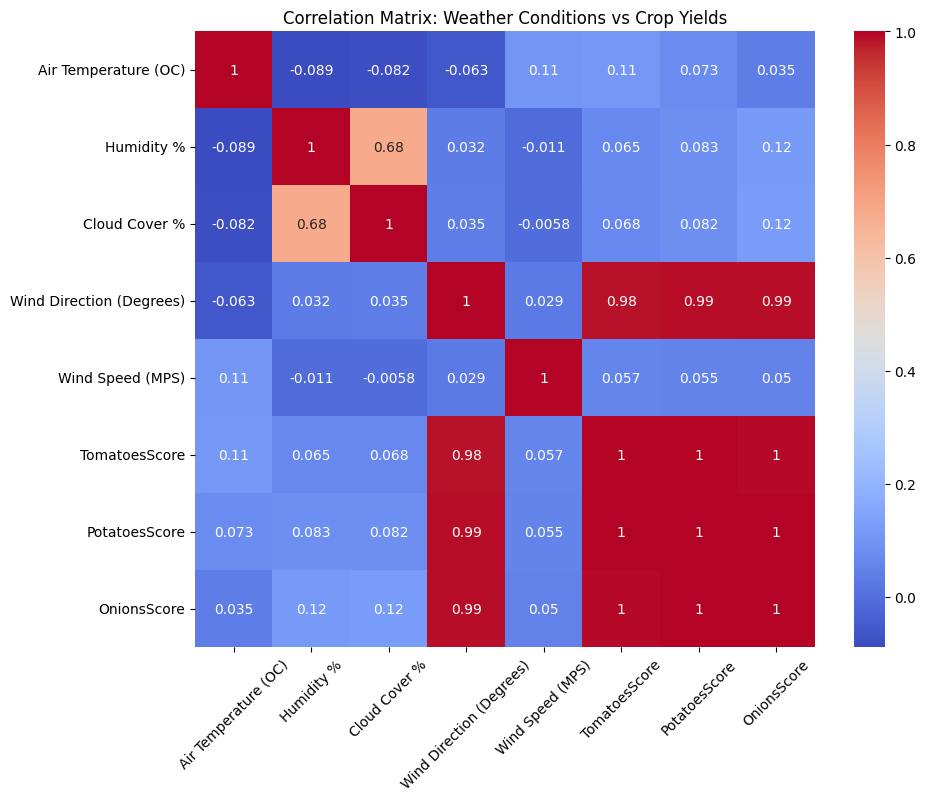

In [ ]:
# Calculate correlation between weather parameters and crop yields
correlation_matrix = df_ghor_cleaned.join(df_ghor_al_safi_crop_production, "Year").select(
    "Air Temperature (OC)",
    "Humidity %",
    "Cloud Cover %",
    "Wind Direction (Degrees)",
    "Wind Speed (MPS)",
    "TomatoesScore",
    "PotatoesScore",
    "OnionsScore"
).toPandas().corr()

# Visualize correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix: Weather Conditions vs Crop Yields")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()


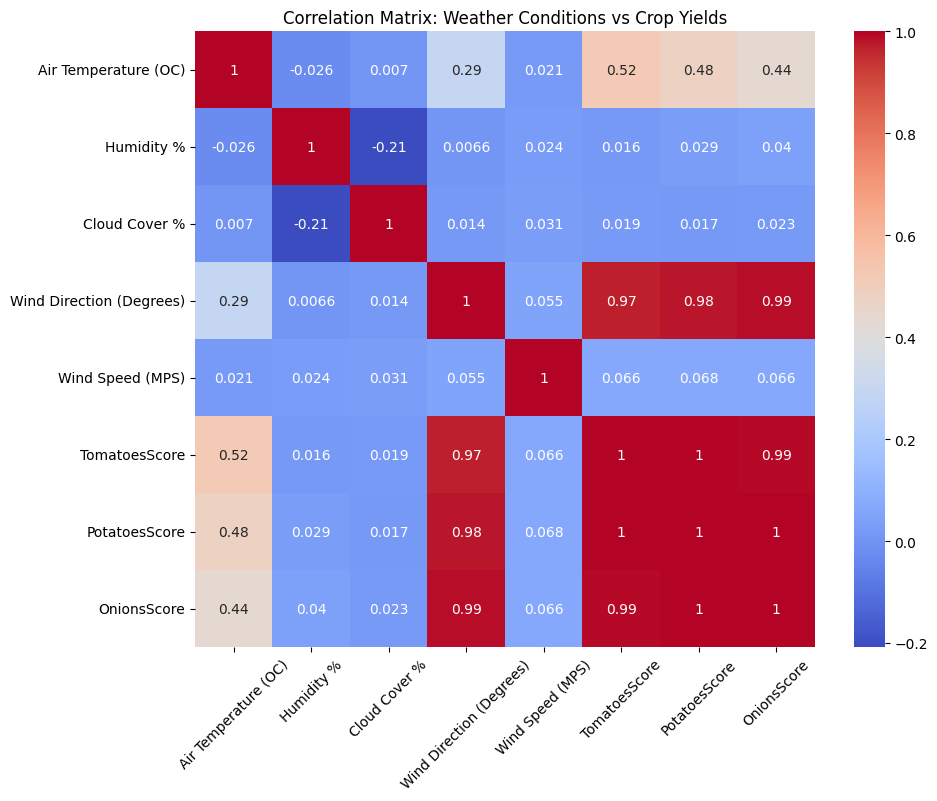

In [ ]:
# Calculate correlation between weather parameters and crop yields
correlation_matrix = df_irbid_cleaned.join(df_irbid_crop_production, "Year").select(
    "Air Temperature (OC)",
    "Humidity %",
    "Cloud Cover %",
    "Wind Direction (Degrees)",
    "Wind Speed (MPS)",
    "TomatoesScore",
    "PotatoesScore",
    "OnionsScore"
).toPandas().corr()

# Visualize correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix: Weather Conditions vs Crop Yields")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()


**Predictive Modelling**

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

# Select the relevant columns for modeling
selected_columns = ["Air Temperature (OC)", "Humidity %", "Cloud Cover %", "Wind Direction (Degrees)", "Wind Speed (MPS)", "TomatoesScore", "PotatoesScore", "OnionsScore"]

# Create a VectorAssembler to combine the weather condition features into a single vector column
assembler = VectorAssembler(inputCols=["Air Temperature (OC)", "Humidity %", "Cloud Cover %", "Wind Direction (Degrees)", "Wind Speed (MPS)"], outputCol="features")

# Apply the VectorAssembler transformation to the DataFrame
df_assembled = assembler.transform(df_irbid_cleaned)

# Split the data into training and testing sets
train_data, test_data = df_assembled.randomSplit([0.7, 0.3])

# Create a LinearRegression model for TomatoesScore
lr_tomatoes = LinearRegression(featuresCol="features", labelCol="TomatoesScore")

# Fit the model to the training data
lr_tomatoes_model = lr_tomatoes.fit(train_data)

# Make predictions on the test data for TomatoesScore
tomatoes_predictions = lr_tomatoes_model.transform(test_data)

# Create a LinearRegression model for PotatoesScore
lr_potatoes = LinearRegression(featuresCol="features", labelCol="PotatoesScore")

# Fit the model to the training data
lr_potatoes_model = lr_potatoes.fit(train_data)

# Make predictions on the test data for PotatoesScore
potatoes_predictions = lr_potatoes_model.transform(test_data)

# Create a LinearRegression model for OnionsScore
lr_onions = LinearRegression(featuresCol="features", labelCol="OnionsScore")

# Fit the model to the training data
lr_onions_model = lr_onions.fit(train_data)

# Make predictions on the test data for OnionsScore
onions_predictions = lr_onions_model.transform(test_data)

# Display the predicted crop yields
predictions = tomatoes_predictions.select("Year", "TomatoesScore", "prediction").join(
    potatoes_predictions.select("Year", "PotatoesScore", "prediction"), on=["Year"]
).join(
    onions_predictions.select("Year", "OnionsScore", "prediction"), on=["Year"]
)

predictions.show()


+----+-------------+------------------+-------------+-----------------+-----------+------------------+
|Year|TomatoesScore|        prediction|PotatoesScore|       prediction|OnionsScore|        prediction|
+----+-------------+------------------+-------------+-----------------+-----------+------------------+
|2017|          3.3|3.2994464678255877|          3.9|3.909686995182956|        4.5| 4.475129760950335|
|2017|          3.3|3.2994464678255877|          3.9|3.909686995182956|        4.4|  4.38091891035917|
|2017|          3.3|3.2994464678255877|          3.9|3.909686995182956|        4.2| 4.179710828586991|
|2017|          3.3|3.2994464678255877|          3.9|3.909686995182956|        4.2| 4.156125940603798|
|2017|          3.3|3.2994464678255877|          3.9|3.909686995182956|        2.7|2.6963535823323683|
|2017|          3.3|3.2994464678255877|          3.9|3.909686995182956|        2.8| 2.829409148739392|
|2017|          3.3|3.2994464678255877|          3.9|3.909686995182956|  